# Stein and Bayes

Some simulations to play around with Stein's shrinkage estimator and a Bayesian model.


The problem:

We want to estimate $n$ means, and we obtain $n$ samples to do so. 
In particular, we are given $n$ samples $y \sim N(\theta, \sigma^2 I_n)$ where $\theta \in R^n$.
Find the best estimator for $\theta$ (in terms of mean square error).

It is straightforward to see that the maximum likelihood estimator (MLE) for this problem is simply $y$ itself.
Surprisingly, [James-Stein](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) showed that this is not optimal in the sense of mean square error!

Instead, he proposes the James-Stein estimator
$\hat \theta = \left(1- \frac{(n-2)\sigma^2}{\| y \|}\right)_+ y$

We compare the performance of the 2 estimators and empirically find that the JS estimator indeed outperforms the MLE estimator.

Finally, we fit a Bayesian model just for fun.


In [1]:
import numpy as np

import pystan

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# number of samples
n = 20

mu0 = 1
sigma = 1

In [3]:
theta = mu0 + np.random.randn(n)
y = theta + sigma * np.random.randn(n)

In [4]:
def mse(estimate, theta):
    """ mean square error """
    n = len(theta)
    return np.sum((estimate - theta) ** 2) / n

def mle(y):
    """ mle estimator is identity function """
    return y

def stein(y, sigma=1):
    """ James-Stein estimator shrinks y (assumes knowledge of sigma) """
    n = len(y)
    return max(0, (1-(n-2)*sigma/(y @ y.T))) * y

In [5]:
mse(mle(y), theta)

0.90127038631422118

In [6]:
mse(stein(y, sigma=1), theta)

0.69898135736031863

In [7]:
stan_data = {"n": len(y), "y": y}

stan_code = """
data {
    int<lower=0> n; // number of data points
    vector[n] y; // samples
}
transformed data {}
parameters {
    real mu0;
    real<lower=0> sigma0;
    real<lower=0> sigma;
    vector[n] theta;
}
model {
    mu0 ~ cauchy(0, 2.5);
    sigma0 ~ cauchy(0, 2.5);
    sigma ~ cauchy(0, 2.5);

    theta ~ normal(mu0, sigma0);
    
    y ~ normal(theta, sigma);
}
"""

niter = 500
stan_fit = pystan.stan(model_code=stan_code, data=stan_data, iter=niter, chains=2)

stan_fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d604887d63d509d2b5aae851718b65a9 NOW.


Inference for Stan model: anon_model_d604887d63d509d2b5aae851718b65a9.
2 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0         1.29    0.02   0.34   0.56    1.1   1.29    1.5   1.91    277   1.01
sigma0      1.08    0.09   0.44   0.25   0.76   1.13   1.41   1.82     22   1.06
sigma       0.91    0.09   0.45    0.2   0.54    0.9   1.23   1.83     26   1.03
theta[0]    1.79    0.07   0.68   0.35   1.35   1.85   2.23   3.13     89   1.01
theta[1]    0.88    0.05   0.65  -0.38   0.45   0.82   1.34   2.13    150   1.02
theta[2]    1.61    0.06    0.6    0.3    1.2   1.61    2.0   2.87    107   1.01
theta[3]    2.23    0.12   0.75   0.79   1.66   2.26   2.81   3.55     39   1.02
theta[4]    1.52    0.03   0.63   0.16   1.15   1.56   1.91   2.71    500    1.0
theta[5]    0.65    0.08   0.67  -0.48   0.15   0.57   1.09   2.01     75   1.02
theta

In [8]:
# grab point estimates
bayesian_pts = np.mean(stan_fit.extract()["theta"], axis=0)
mse(bayesian_pts, theta)

0.53281509434213414

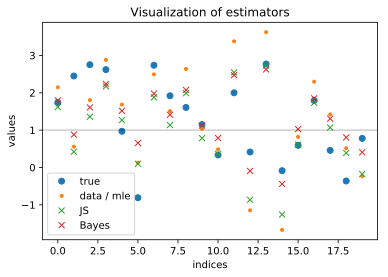

In [9]:
f, ax = plt.subplots()
ax.plot(theta, marker="o", linestyle=" ")
ax.plot(y, marker=".", linestyle=" ")
ax.plot(stein(y, sigma=sigma), marker="x", linestyle=" ")
ax.plot(bayesian_pts, marker="x", linestyle=" ")

ax.axhline(mu0, color="black", alpha=0.2)

ax.legend(["true", "data / mle", "JS", "Bayes"])

ax.set_title("Visualization of estimators")
ax.set_xlabel("indices")
ax.set_ylabel("values")

We notice that the JS and Bayesian estimators significantly outperform the intuitive MLE estimator.

## James-Stein with varying $\sigma$

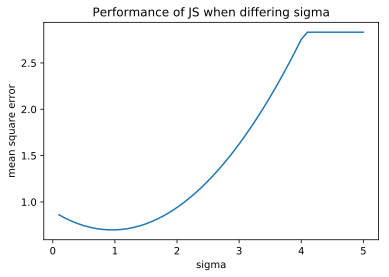

In [10]:
S = np.linspace(0.1, 5, 50)

f, ax = plt.subplots()
ax.plot(S, [mse(stein(y, sigma=s), theta) for s in S])

ax.set_title("Performance of JS when differing sigma")
ax.set_xlabel("sigma")
ax.set_ylabel("mean square error")

## Matt's trick

In [ ]:
# with Matt's trick
stan_code = """
data {
    int<lower=0> n; // number of data points
    vector[n] y; // samples
}
transformed data {}
parameters {
    real mu0;
    real<lower=0> sigma0;
    real<lower=0> sigma;
    vector[n] theta_err;
}
transformed parameters {
    vector[n] theta;
    theta = mu0 + sigma0 * theta_err;
}
model {
    mu0 ~ cauchy(0, 2.5);
    sigma0 ~ cauchy(0, 2.5);
    sigma ~ cauchy(0, 2.5);

    theta_err ~ normal(0, 1);
    
    y ~ normal(theta, sigma);
}
"""